# Analysis of NIL reprogramming with different dropouts and NT drop out
Notes:

1. Only singlets are included

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest
import rushd as rd
import re
from pathlib import Path

# Required descriptors for annotate
from scipy.stats import ttest_ind
custom_long_name = 't-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_greater'
custom_func = ttest_ind
ttest_ind_greater = StatTest(custom_func, custom_long_name, custom_short_name, alternative='greater')

custom_long_name = 't-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_less'
custom_func = ttest_ind
ttest_ind_less = StatTest(custom_func, custom_long_name, custom_short_name, alternative='less')

## Load data

In [3]:
# Directories
base_datadir = rd.datadir/'2022.11.06_no_NT'
figpath = '../figures/fig5/'

# List of data folder names
dir_list = ['2022.06.13_no_NT_01', '2022.11.06_no_NT_02']

# Store all data in list of dfs which will be converted to df at end
data = list()

# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list):

    datadir = base_datadir/dir_name/'export_singlets'
    files = Path(datadir).glob('*.csv') 

    for i, file in enumerate(files):

        # Extract metadata from csv title
        match = re.search(
            'export_(?P<cond>.+)_(?P<sampleNum>\d)_Singlets.csv', file.name)
        # If no match, keep going
        if match is None:
            print('No match for {}'.format(file.name))
            continue

        # Load as df and note header is on 0th row
        df = pd.read_csv(file, header=0)

        # Update columns in df with metadata from file name
        df['cond'] = match.group('cond')
        df['sampleNum'] = int(match.group('sampleNum'))
        df['replicate'] = j

        # Add df to list
        data.append(df)

# Convert list of dfs into single df
data = pd.concat(data, ignore_index=True)

# Remove negative data
data = data.loc[
    (data['GFP-A'] > 0)
]

Import Koch data

In [5]:
# Store all data in list of dfs which will be converted to df at end
data_KI = list()

datadir = rd.datadir/'2023.10.20_BAL-noNT'/'export_singlets'
files = Path(datadir).glob('*.csv') 

# Increment bio rep
j = j+1
for i, file in enumerate(files):

    # Extract metadata from csv title
    match = re.search(
        'export_(?P<cond>.+)_(?P<sampleNum>\d)_Singlets.csv', file.name)
    # If no match, keep going
    if match is None:
        print('No match for {}'.format(file.name))
        continue

    # Load as df and note header is on 0th row
    df = pd.read_csv(file, header=0)

    # Update columns in df with metadata from file name
    df['cond'] = match.group('cond')
    df['sampleNum'] = int(match.group('sampleNum'))
    df['replicate'] = j

    # Add df to list
    data_KI.append(df)

# Convert list of dfs into single df
data_KI = pd.concat(data_KI, ignore_index=True)

# Remove negative data
data_KI = data_KI.loc[
    (data_KI['FITC-A'] > 0)
]

## Categorize eGFP+ cells
### Define eGFP cut-off for non-KI

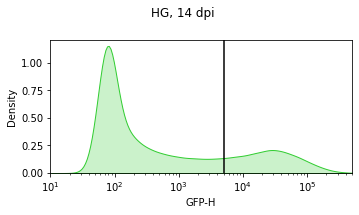

In [ ]:
# Threshold for iMNs
GFP_thresh = 5*10**3

# Plot GFP-H
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
x = 'GFP-H'
sns.kdeplot(data=data.loc[(data['cond'] == 'NIL-DDRR_NTs')],
        ax=ax, x=x,
        common_norm = False, log_scale=(True, False),
        fill=True, color='limegreen')
ax.axvline(GFP_thresh, 0, 1, color='black')

# Title
plt.suptitle('HG, 14 dpi')
# Adjust limits
GFP_lim = (10, 5*10**5)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(GFP_lim)

# Misc plotting stuff
fig.tight_layout()  # Helps improve white spacing

In [7]:
# Categorize iMNs based on eGFP_thresh
data['GFP_cat'] = 'fib'
data.loc[(data['GFP-H'] > GFP_thresh), 'GFP_cat'] = 'iMN'

# Get total counts and percent of GFP-H+
well_group = ['cond', 'replicate']
count_df_reps = data.groupby([*well_group, 'sampleNum', 'GFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no eGFP-H+ rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'sampleNum']).transform('sum')).dropna().reset_index(name='percent')

# Extract just the iMNs
data_iMN_percent_reps_nonKI = percent_df_reps.loc[(percent_df_reps['GFP_cat'] == 'iMN')]

# Get iMN yield per condition
seedNum = 10**4 # Seeded 10k MEFs/96-wel
# Divide by seeded cells to get yield, then extract just the iMNs
data_iMN_yield_reps_nonKI = (count_df_reps*100/seedNum).reset_index(name='yield')
data_iMN_yield_reps_nonKI = data_iMN_yield_reps_nonKI.loc[data_iMN_yield_reps_nonKI['GFP_cat'] == 'iMN']

# Reduce to bio reps
data_iMN_percent_nonKI = data_iMN_percent_reps_nonKI.groupby(well_group)['percent'].mean().reset_index()
data_iMN_yield_nonKI = data_iMN_yield_reps_nonKI.groupby(well_group)['yield'].mean().reset_index()

### Do again for KI

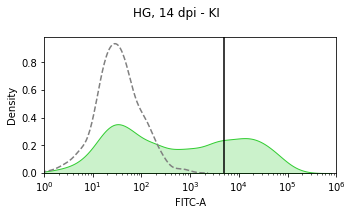

In [ ]:
# Threshold for iMNs
FITC_thresh = 5*10**3

# Plot FITC
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
x = 'FITC-A'
sns.kdeplot(data=data_KI.loc[(data_KI['cond'] == 'NIL-HIP-W_NTs_RS')],
        ax=ax, x=x,
        common_norm = False, log_scale=(True, False),
        fill=True, color='limegreen')
ax.axvline(FITC_thresh, 0, 1, color='black')

# Plot neg
sns.kdeplot(data=data_KI.loc[(data_KI['cond'] == 'NIL_NoNTs')],
        ax=ax, x=x,
        common_norm = False, log_scale=(True, False),
        fill=False, color='grey', linestyle='--')

# Title
plt.suptitle('HG, 14 dpi - KI')
# Adjust limits
FITC_lim = (1, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(FITC_lim)

# Misc plotting stuff
fig.tight_layout()  # Helps improve white spacing

In [9]:
# Categorize iMNs based on eGFP_thresh
data_KI['FITC_cat'] = 'fib'
data_KI.loc[(data_KI['FITC-A'] > FITC_thresh), 'FITC_cat'] = 'iMN'

# Get total counts and percent of GFP-H+
well_group = ['cond', 'replicate']
count_df_reps = data_KI.groupby([*well_group, 'sampleNum', 'FITC_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no eGFP-H+ rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'sampleNum']).transform('sum')).dropna().reset_index(name='percent')

# Extract just the iMNs
data_iMN_percent_reps_KI = percent_df_reps.loc[(percent_df_reps['FITC_cat'] == 'iMN')]

# Get iMN yield per condition
seedNum = 10**4 # Seeded 10k MEFs/96-wel
# Divide by seeded cells to get yield, then extract just the iMNs
data_iMN_yield_reps_KI = (count_df_reps*100/seedNum).reset_index(name='yield')
data_iMN_yield_reps_KI = data_iMN_yield_reps_KI.loc[data_iMN_yield_reps_KI['FITC_cat'] == 'iMN']

# Reduce to bio reps
data_iMN_percent_KI = data_iMN_percent_reps_KI.groupby(well_group)['percent'].mean().reset_index()
data_iMN_yield_KI = data_iMN_yield_reps_KI.groupby(well_group)['yield'].mean().reset_index()

### Combine both data sets

In [10]:
data_iMN_yield_reps = pd.concat([data_iMN_yield_reps_nonKI, data_iMN_yield_reps_KI], ignore_index=True)
data_iMN_yield = pd.concat([data_iMN_yield_nonKI, data_iMN_yield_KI], ignore_index=True)
data_iMN_percent_reps = pd.concat([data_iMN_percent_reps_nonKI, data_iMN_percent_reps_KI], ignore_index=True)
data_iMN_percent = pd.concat([data_iMN_percent_nonKI, data_iMN_percent_KI], ignore_index=True)

## Plot iMN yield and percent

# Look at with and without NT

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL_NTs vs. NIL_NoNTs: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:3.914e-02 Stat=2.353e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


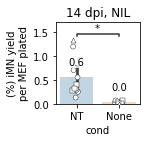

In [12]:
# Plotting params
x = 'cond'
units = 'sampleNum'
cond_list = ['NIL_NTs', 'NIL_NoNTs']
marker_list = ['o', 's', '^', 'D']

# Plot
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

# Plot iMN yield
y = 'yield'
f = sns.barplot(ax=ax, data=data_iMN_yield_reps,
                x=x, y=y, order=cond_list,
                units=units, alpha=0.3)
for (i, rep) in enumerate(data_iMN_yield_reps.replicate.unique()):
    sns.stripplot(
        ax=ax, data=data_iMN_yield_reps[data_iMN_yield_reps.replicate == rep],
        x=x, y=y, order=cond_list,
        dodge=True, marker=marker_list[i],
        color='white', size=5,
        edgecolor='black', linewidth=0.4,)

# Pairs for stats comp
pairs = [('NIL_NTs', 'NIL_NoNTs')]
# Add in stats for iMN yield
annot = Annotator(ax=ax, data=data_iMN_yield, x=x, y=y, pairs=pairs, order=cond_list)
annot.configure(test=ttest_ind_greater, text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.1f', padding=10)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

# Format
f.set_xticklabels(['NT', 'None'])
ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
# ax.yaxis.set_ticks(np.arange(0, 1.6, 0.4))
# ax.set_box_aspect(4/len(ax.patches)) #change 10 to modify the y/x axis ratio
plt.title('14 dpi, NIL')
# fig.tight_layout()  # Helps improve white spacing

# plt.savefig(figpath + 'bar_yield_noNT_NIL_new-smaller.svg', bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL_NTs vs. NIL_NoNTs: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:3.914e-02 Stat=2.353e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


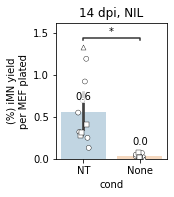

In [ ]:
# Plotting params
x = 'cond'
units = 'sampleNum'
cond_list = ['NIL_NTs', 'NIL_NoNTs']
marker_list = ['o', 's', '^', 'D']

# Plot
fig, ax = plt.subplots(1, 1, figsize=(2, 2.5))

# Plot iMN yield
y = 'yield'
f = sns.barplot(ax=ax, data=data_iMN_yield_reps,
                x=x, y=y, order=cond_list,
                units=units, alpha=0.3)
for (i, rep) in enumerate(data_iMN_yield_reps.replicate.unique()):
    sns.stripplot(
        ax=ax, data=data_iMN_yield_reps[data_iMN_yield_reps.replicate == rep],
        x=x, y=y, order=cond_list,
        dodge=True, marker=marker_list[i],
        color='white', size=5,
        edgecolor='black', linewidth=0.4,)

# Pairs for stats comp
pairs = [('NIL_NTs', 'NIL_NoNTs')]
# Add in stats for iMN yield
annot = Annotator(ax=ax, data=data_iMN_yield, x=x, y=y, pairs=pairs, order=cond_list)
annot.configure(test=ttest_ind_greater, text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.1f', padding=10)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

# Format
f.set_xticklabels(['NT', 'None'])
ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
# ax.yaxis.set_ticks(np.arange(0, 1.6, 0.4))
# ax.set_box_aspect(4/len(ax.patches)) #change 10 to modify the y/x axis ratio
plt.title('14 dpi, NIL')
# fig.tight_layout()  # Helps improve white spacing

# plt.savefig(figpath + 'bar_yield_noNT_NIL_new.svg', bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL_NTs vs. NIL_NoNTs: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:1.448e-01 Stat=1.219e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


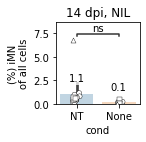

In [ ]:
# Plotting params
x = 'cond'
units = 'sampleNum'
cond_list = ['NIL_NTs', 'NIL_NoNTs']
marker_list = ['o', 's', '^', 'D']

# Plot
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

# Plot iMN yield
y = 'percent'
f = sns.barplot(ax=ax, data=data_iMN_percent_reps,
                x=x, y=y, order=cond_list,
                units=units, alpha=0.3)
for (i, rep) in enumerate(data_iMN_percent_reps.replicate.unique()):
    sns.stripplot(
        ax=ax, data=data_iMN_percent_reps[data_iMN_percent_reps.replicate == rep],
        x=x, y=y, order=cond_list,
        dodge=True, marker=marker_list[i],
        color='white', size=5,
        edgecolor='black', linewidth=0.4,)

# Pairs for stats comp
pairs = [('NIL_NTs', 'NIL_NoNTs')]
# Add in stats for iMN yield
annot = Annotator(ax=ax, data=data_iMN_percent, x=x, y=y, pairs=pairs, order=cond_list)
annot.configure(test=ttest_ind_greater, text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.1f', padding=10)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

# Format
f.set_xticklabels(['NT', 'None'])
ax.yaxis.set_label_text('(%) iMN\nof all cells')
# ax.yaxis.set_ticks(np.arange(0, 1.3, 0.4))
# ax.set_box_aspect(4/len(ax.patches)) #change 10 to modify the y/x axis ratio
plt.title('14 dpi, NIL')
# fig.tight_layout()  # Helps improve white spacing

# plt.savefig(figpath + 'SI/bar_percent_noNT_NIL_new-smaller.svg', bbox_inches='tight')

## Plot all together

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL-HIP-W_NTs_RS vs. NIL-HIP-W_NoNTs_RS: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-6.041e-01
NIL-HIP-W_NoNTs_RS vs. NIL-HIP-W_NoNTs_NoRS: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-3.123e-01
NIL-HIP-W_NTs_RS vs. NIL-HIP-W_NoNTs_NoRS: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-9.810e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL_NTs vs. NIL_NoNTs: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:3.914e-02 

/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position fou

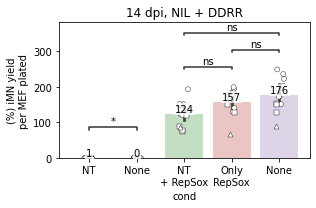

In [ ]:
# Plotting params
x = 'cond'
units = 'sampleNum'
marker_list = ['o', 's', '^', 'D']

# Conditions
cond_list = ['NIL_NTs', 'NIL_NoNTs', 'NIL-HIP-W_NTs_RS', 'NIL-HIP-W_NoNTs_RS', 'NIL-HIP-W_NoNTs_NoRS']

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4.5, 2.5))


# Plot iMN yield
y = 'yield'
f = sns.barplot(ax=ax, data=data_iMN_yield_reps,
                x=x, y=y, order=cond_list,
                units=units, alpha=0.3)
for (i, rep) in enumerate(data_iMN_yield_reps.replicate.unique()):
    sns.stripplot(
        ax=ax, data=data_iMN_yield_reps[data_iMN_yield_reps.replicate == rep],
        x=x, y=y, order=cond_list,
        dodge=True, marker=marker_list[i],
        color='white', size=5,
        edgecolor='black', linewidth=0.4,)

# Pairs for stats comp
pairs = [('NIL-HIP-W_NTs_RS', 'NIL-HIP-W_NoNTs_RS'),
    ('NIL-HIP-W_NTs_RS', 'NIL-HIP-W_NoNTs_NoRS'),
    ('NIL-HIP-W_NoNTs_RS', 'NIL-HIP-W_NoNTs_NoRS')]
# Add in stats for iMN yield
annot = Annotator(ax=ax, data=data_iMN_yield, x=x, y=y, pairs=pairs, order=cond_list)
annot.configure(test='t-test_ind', comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.2)
# Add in NIL separately
pairs = [('NIL_NTs', 'NIL_NoNTs')]
annot = Annotator(ax=ax, data=data_iMN_yield, x=x, y=y, pairs=pairs, order=cond_list)
annot.configure(test=ttest_ind_greater, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.2)

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=0)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

# Format
f.set_xticklabels([
    'NT', 'None',
    'NT\n+ RepSox', 'Only\nRepSox', 'None'])
ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
ax.yaxis.set_ticks(np.arange(0, 400, 100))
ax.set_ylim((0, 380))
plt.title('14 dpi, NIL + DDRR')
# fig.tight_layout()  # Helps improve white spacing

# plt.savefig(figpath + 'bar_yield_noNT_NILDDRR_new.svg', bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL-HIP-W_NTs_RS vs. NIL-HIP-W_NoNTs_RS: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-4.613e-01
NIL-HIP-W_NoNTs_RS vs. NIL-HIP-W_NoNTs_NoRS: t-test independent samples with Bonferroni correction, P_val:9.146e-01 t=1.176e+00
NIL-HIP-W_NTs_RS vs. NIL-HIP-W_NoNTs_NoRS: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=3.152e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL_NTs vs. NIL_NoNTs: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.448e-01 St

/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position fou

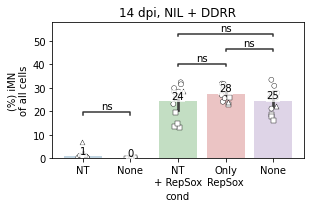

In [ ]:
# Plotting params
x = 'cond'
units = 'sampleNum'
marker_list = ['o', 's', '^', 'D']

# Conditions
cond_list = ['NIL_NTs', 'NIL_NoNTs', 'NIL-HIP-W_NTs_RS', 'NIL-HIP-W_NoNTs_RS', 'NIL-HIP-W_NoNTs_NoRS']

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4.5, 2.5))


# Plot iMN percent
y = 'percent'
f = sns.barplot(ax=ax, data=data_iMN_percent_reps,
                x=x, y=y, order=cond_list,
                units=units, alpha=0.3)
for (i, rep) in enumerate(data_iMN_yield_reps.replicate.unique()):
    sns.stripplot(
        ax=ax, data=data_iMN_percent_reps[data_iMN_percent_reps.replicate == rep],
        x=x, y=y, order=cond_list,
        dodge=True, marker=marker_list[i],
        color='white', size=5,
        edgecolor='black', linewidth=0.4,)

# Pairs for stats comp
pairs = [('NIL-HIP-W_NTs_RS', 'NIL-HIP-W_NoNTs_RS'),
    ('NIL-HIP-W_NTs_RS', 'NIL-HIP-W_NoNTs_NoRS'),
    ('NIL-HIP-W_NoNTs_RS', 'NIL-HIP-W_NoNTs_NoRS')]
# Add in stats for iMN yield
annot = Annotator(ax=ax, data=data_iMN_percent, x=x, y=y, pairs=pairs, order=cond_list)
annot.configure(test='t-test_ind', comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.2)
# Add in NIL separately
pairs = [('NIL_NTs', 'NIL_NoNTs')]
annot = Annotator(ax=ax, data=data_iMN_percent, x=x, y=y, pairs=pairs, order=cond_list)
annot.configure(test=ttest_ind_greater, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.2)

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=0)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

# Format
f.set_xticklabels([
    'NT', 'None',
    'NT\n+ RepSox', 'Only\nRepSox', 'None'])
ax.yaxis.set_label_text('(%) iMN\nof all cells')
# ax.yaxis.set_ticks(np.arange(0, 400, 100))
# ax.set_ylim((0, 380))
plt.title('14 dpi, NIL + DDRR')
# fig.tight_layout()  # Helps improve white spacing

# plt.savefig(figpath + 'SI/bar_percent_noNT_NILDDRR_new.svg', bbox_inches='tight')